## Example of approximating 1D functions with a single layer neural network

In [32]:
import torch
import matplotlib.pyplot as plt
from fastai.data.all import *
from fastai.callback.all import *
from fastai.learner import Learner

#### Change to the function you want to interpolate
It uses [-1, 1] as domain. It works the best if the codomain is close to that range as well. For other ranges and it should work but needed more training steps.

In [33]:
def func(x):
    return .5-x*x+torch.cos(5*torch.sin(8*x))/2
    

#### Creating a fastai `DataLoaders` instance

It contains 10000 random points from the range [-1, 1]

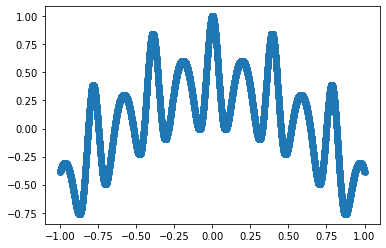

In [34]:
def get_dls(f, bs):
    x = 2 * torch.rand(10000) - 1
    y = func(x)
    plt.scatter(x,y)
    db = DataBlock(get_x = lambda x:x[0], get_y=lambda x:x[1])
    data = torch.stack((x,y),dim=1)
    return db.dataloaders(data,bs=bs, device=torch.device('cpu'), valid_pct=10)

dls = get_dls(func, 50)

#### A simple model with a single linear layer
I fiddled with the activation function and initialization of the paramaters to make it train well on this problem.
Rather than the standard relu(W * x + B) it uses abs(x + B) / W clamped to (0,1). It has the same expressive power, but in my experiments I was able to train it faster and more consistently.

In [35]:
class BarModule(torch.nn.Module):
    def __init__(self, n):
        super().__init__()
        self.w1 = nn.Parameter(2 * torch.ones(n) / n )
        self.b = nn.Parameter(torch.rand(n) * 2 - 1)
        self.w2 = nn.Parameter(torch.randn(n) / 10)
       
    def forward(self, x):
        x = x[:,None]
        dist = torch.abs(x + self.b) / self.w1
        res = 1 - dist.clamp(0,1)
        res = res * self.w2
        return torch.sum(res, dim=1) 

#### A helper class to display progress of the training

In [43]:
class ShowChart(Callback):
    
    def __init__(self, figsize=(10,10)):
        self.figsize = figsize
        self.dx = torch.linspace(-1,1,1000)
        self.dy = func(self.dx)
        self.miny = self.dy.min().item()
        self.maxy = self.dy.max().item()
        self.bc = 0
    def after_batch(self):
        self.bc +=1
        if self.bc % 20 == 0:
            self.update_graph()
    
    
    def before_fit(self):
        graph_fig, self.graph_ax = plt.subplots(1, figsize=self.figsize)
        plt.close()
        self.graph_out = display(self.graph_ax.figure, display_id=True)
        self.update_graph()
        
    def update_graph(self):
        if not hasattr(self, 'graph_ax'): return
        model = self.learn.model    
        prediction = model(self.dx).detach()
        self.graph_ax.clear()
        self.graph_ax.set_ylim(self.miny, self.maxy)
        self.graph_ax.plot(self.dx, self.dy, label='actual')
        self.graph_ax.plot(self.dx,prediction, label = 'pred')
        self.graph_ax.legend(loc='lower left');
        self.graph_out.update(self.graph_ax.figure)
       

#### Creating a model instance and the Learner. Change the value of the `n` argument to modify the number of neurons used

In [46]:
nbr_neurons = 20
bm = BarModule(nbr_neurons)
learn = Learner(dls,bm, loss_func=nn.MSELoss(), cbs = ShowChart)

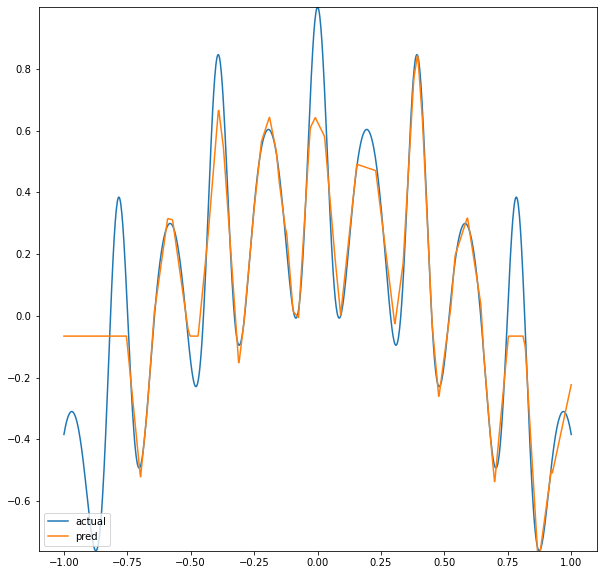

epoch,train_loss,valid_loss,time
0,0.103903,0.088662,00:02
1,0.070250,0.061647,00:02
2,0.052610,0.048325,00:02
3,0.040738,0.038817,00:02
4,0.033959,0.032873,00:02


In [47]:
learn.fit(5, lr=1e-3 )